In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
%%capture
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
%%capture
!kaggle datasets download -d ipateam/nuinsseg
!unzip -q ./nuinsseg.zip -d ./Dataset-Nuclei

# Dependencies

In [5]:
!pip install -q pycocotools

In [6]:
import os
import copy
import random
import json
import glob
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from   zipfile import ZipFile
import argparse
import shutil


from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.utils.data
from torch import nn
import torchvision


from torchvision import transforms as T

from pycocotools import mask as coco_mask
from pycocotools.coco import COCO


**DATA PREPARATION**

In [7]:
"""
Clean up of the Nuclei dataset
Can be downloaded from: https://www.kaggle.com/datasets/ipateam/nuinsseg?resource=download

The dataset comes with a lot of subdirectories that can be very useful depending
on the task of your interest. For our Mask RCNN and Ultralytics training, we just
need the raw images and labeled masks that we will convert to appropriate formats.
So let us delete all unwanted data and keep only the raw images, binary masks
and label masks.

Keep the directories with names 'tissue images', 'mask binary without border', and 'label masks modify'

"""


def prune_subdirectories(base_dir,keep_dirs):
    #Iterate through each subdirs in base dir
    for root_dir in os.listdir(base_dir):
        root_path = os.path.join(base_dir,root_dir)
        if os.path.isdir(root_path):
          #  print(f"Processing: {root_path}")
           #List all subdirs inside the current root dir
           for sub_dir in os.listdir(root_path):
               sub_path = os.path.join(root_path, sub_dir)
               #If the subdirectory isn't in the keep list, delete it
               if os.path.isdir(sub_path) and sub_dir not in keep_dirs:
                  # print(f"Deleting: {sub_path}")
                  shutil.rmtree(sub_path)
               elif os.path.isdir(sub_path):
                  # print(f"Keeping: {sub_path}")
                  pass


base_directory = "Dataset-Nuclei"
directories_to_keep = ['tissue images', 'mask binary witthout border', 'label masks modify']

prune_subdirectories(base_directory,directories_to_keep)



In [8]:
# Install Pip Tree globally
%%capture
!sudo apt install tree

In [9]:
!tree --dirsfirst -L 2  "Dataset-Nuclei"

Dataset-Nuclei
├── human bladder
│   ├── label masks modify
│   └── tissue images
├── human brain
│   ├── label masks modify
│   └── tissue images
├── human cardia
│   ├── label masks modify
│   └── tissue images
├── human cerebellum
│   ├── label masks modify
│   └── tissue images
├── human epiglottis
│   ├── label masks modify
│   └── tissue images
├── human jejunum
│   ├── label masks modify
│   └── tissue images
├── human kidney
│   ├── label masks modify
│   └── tissue images
├── human liver
│   ├── label masks modify
│   └── tissue images
├── human lung
│   ├── label masks modify
│   └── tissue images
├── human melanoma
│   ├── label masks modify
│   └── tissue images
├── human muscle
│   ├── label masks modify
│   └── tissue images
├── human oesophagus
│   ├── label masks modify
│   └── tissue images
├── human pancreas
│   ├── label masks modify
│   ├── tissue images
│   └── Thumbs.db
├── human peritoneum
│   ├── label masks modify
│   └── tissue images
├── human placenta
│   ├─

# **Convert Label Masks to Coco Json Single File annotations**

In [10]:
"""
With this code, we will convert our labeled mask image annotations to coco json
format so they can be used in training Mask R-CNN.

"""
def get_image_mask_pairs(data_dir):
    image_paths = []
    mask_paths = []

    for root,_,files in os.walk(data_dir):
        if 'tissue images' in root:
            for file in files:
                if file.endswith('.png'):
                    image_paths.append(os.path.join(root,file))
                    mask_paths.append(os.path.join(root.replace('tissue images','label masks modify'), file.replace('.png','.tif')))
    return image_paths, mask_paths


In [11]:
def mask_to_polygons(mask,epsilon=1.0):
    contours,_ = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:
           poly = contour.reshape(-1).tolist()
           if len(poly) > 4: #Ensures valid polygon
              polygons.append(poly)
    return polygons

In [12]:
def process_data(image_paths, mask_paths, output_dir,train=True):
    annotations = []
    images = []
    image_id = 0
    ann_id = 0

    for img_path, mask_path in zip(image_paths, mask_paths):
        image_id += 1
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # Copy image to output directory
        shutil.copy(img_path, os.path.join(output_dir, os.path.basename(img_path)))

        images.append({
            "id": image_id,
            "file_name": os.path.basename(img_path),
            "height": img.shape[0],
            "width": img.shape[1]
        })

        unique_values = np.unique(mask)
        for value in unique_values:
            if value == 0:  # Ignore background
                continue

            object_mask = (mask == value).astype(np.uint8) * 255
            polygons = mask_to_polygons(object_mask)

            for poly in polygons:
                ann_id += 1
                annotations.append({
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": 1,  # Only one category: Nuclei
                    "segmentation": [poly],
                    "area": cv2.contourArea(np.array(poly).reshape(-1, 2)),
                    "bbox": list(cv2.boundingRect(np.array(poly).reshape(-1, 2))),
                    "iscrowd": 0
                })

    coco_input = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": 1, "name": "Nuclei"}]
    }

    if train:
        with open(os.path.join(output_dir, 'instances_train2017.json'), 'w') as f:
            json.dump(coco_input, f)
    else:
        with open(os.path.join(output_dir, 'instances_val2017.json'), 'w') as f:
            json.dump(coco_input, f)

#instances_train2017.json

In [13]:
def main():
    data_dir = 'Dataset-Nuclei'
    output_dir = 'Nuclei_Instance_COCO_input'
    train_dir = os.path.join(output_dir, 'train2017') #we will stick with naming from official repo scripts
    val_dir = os.path.join(output_dir, 'val2017')

    # Create output directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    image_paths, mask_paths = get_image_mask_pairs(data_dir)

    # Split data into train and val
    train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

    # Process train and val data
    process_data(train_img_paths, train_mask_paths, train_dir,train=True)
    process_data(val_img_paths, val_mask_paths, val_dir,train=False)

if __name__ == '__main__':
    main()

In [14]:
!mkdir ./Nuclei_Instance_COCO_input/annotations
!mv ./Nuclei_Instance_COCO_input/train2017/instances_train2017.json  ./Nuclei_Instance_COCO_input/annotations/
!mv ./Nuclei_Instance_COCO_input/val2017/instances_val2017.json  ./Nuclei_Instance_COCO_input/annotations/

!mkdir -p ./Nuclei_Instance_COCO_input/outputs/training/nuclei_instance_out
!mkdir -p ./Nuclei_Instance_COCO_input/outputs/inference/nuclei_instance_out

In [15]:
!tree --dirsfirst -L 1 "Nuclei_Instance_COCO_input"

Nuclei_Instance_COCO_input
├── annotations
├── outputs
├── train2017
└── val2017

4 directories, 0 files


In [16]:
!tree --dirsfirst -L 1 "Nuclei_Instance_COCO_input/annotations"

Nuclei_Instance_COCO_input/annotations
├── instances_train2017.json
└── instances_val2017.json

0 directories, 2 files


**Visualise Coco Label - Dataset visualise - Only Contours**

In [19]:
 def display_images_with_coco_annotations(image_paths, annotations, display_type='both',filled=True):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        # Generate random colors for each annotation
        colors = [tuple(np.random.rand(3)) for _ in img_annotations]

        for ann, color in zip(img_annotations, colors):
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                                         linewidth=1, edgecolor=color,
                                         facecolor='none')
                ax.add_patch(rect)


              # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    if filled == False:
                       polygon = patches.Polygon(poly, closed=True, edgecolor=color,
                                       fill=False)
                    else:
                       polygon = patches.Polygon(poly, closed=True, edgecolor=color,
                                                fill=True,facecolor=color,alpha=0.7)

                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()


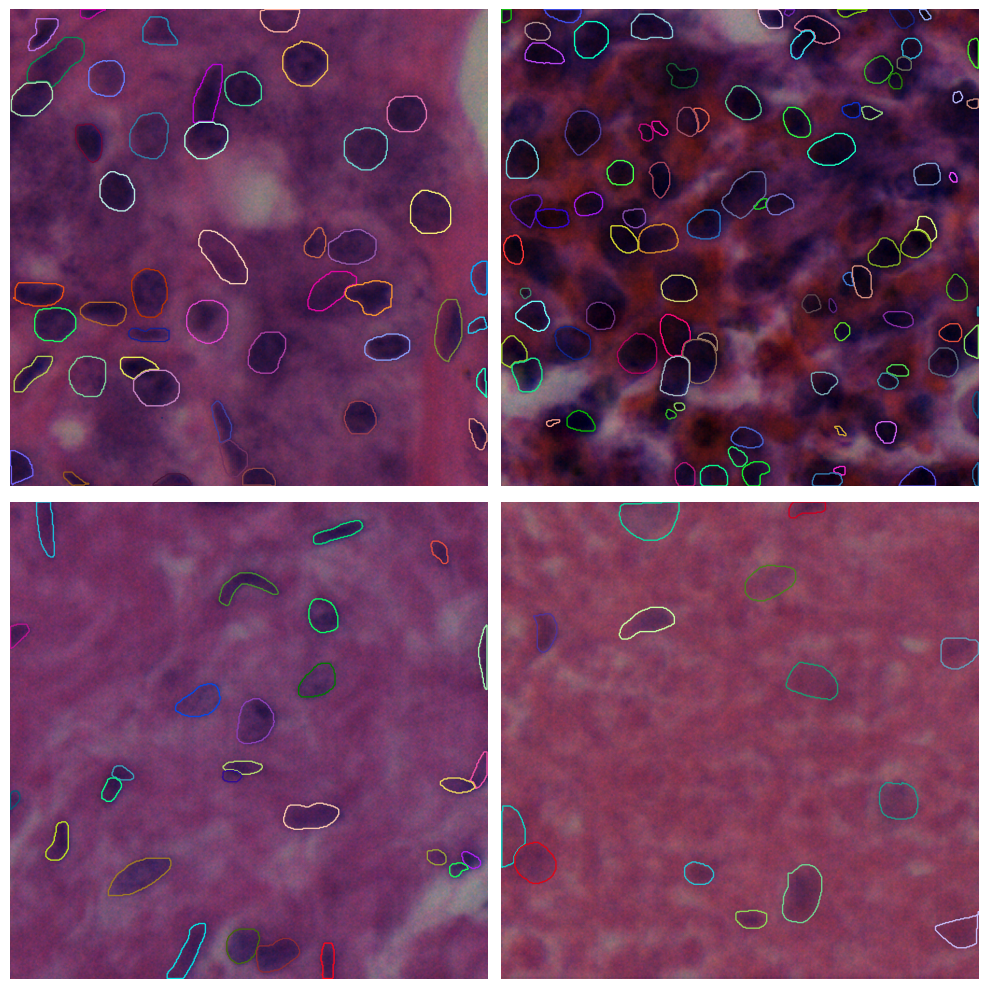

In [20]:
# Load COCO annotations
with open('Nuclei_Instance_COCO_input/annotations/instances_train2017.json','r') as f:
     annotations = json.load(f)

# Get all image files
image_dir = "Nuclei_Instance_COCO_input/train2017"
all_images_files = [os.path.join(image_dir,img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_images_files,4)

# Choose between 'bbox', 'seg', or 'both'
display_type = "seg"
display_images_with_coco_annotations(random_image_files,annotations,display_type,filled=False)

**Visualise Labels filled**

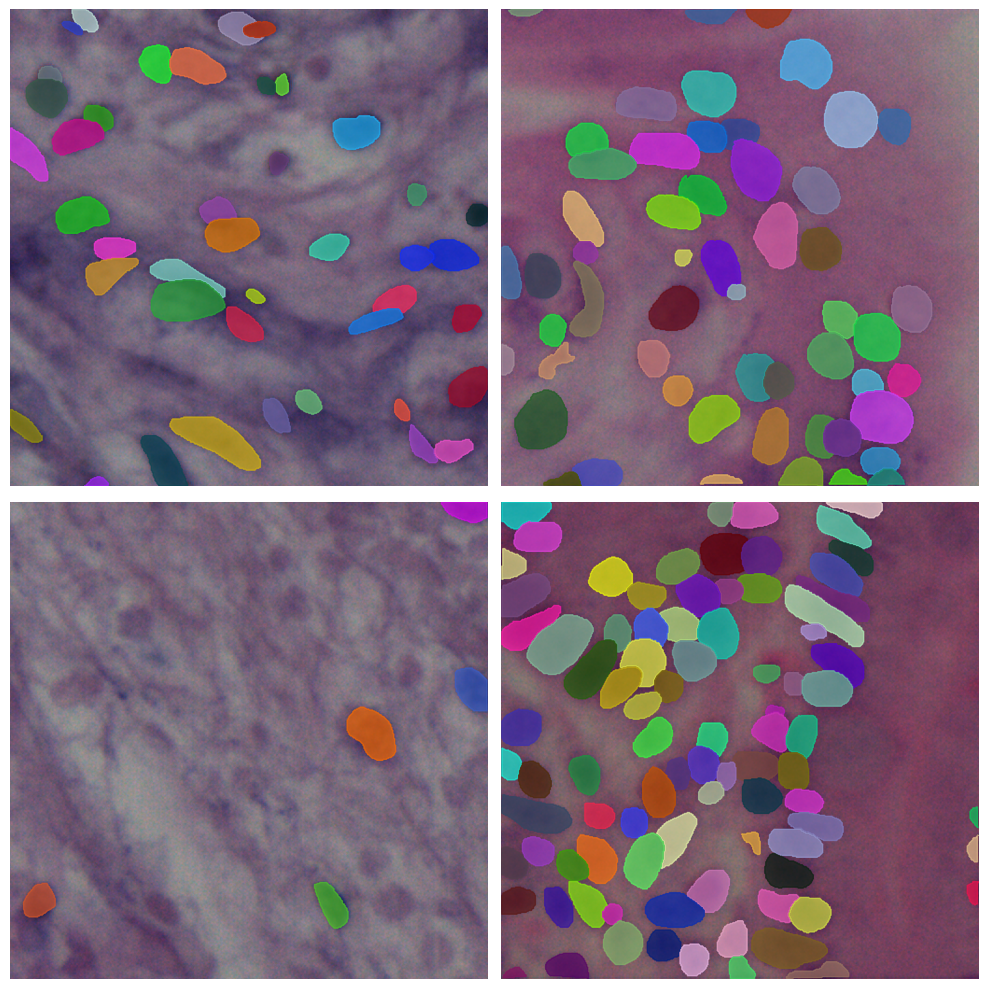

In [23]:
# Load COCO annotations
with open('Nuclei_Instance_COCO_input/annotations/instances_val2017.json', 'r') as f:
    annotations = json.load(f)


# Get all image files
image_dir = "Nuclei_Instance_COCO_input/val2017"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type,filled=True)

**Download scripts**

In [ ]:
# Download and dataset.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # Extract tarfile.
        if save_path.endswith(".zip"):
            with ZipFile(save_path) as zip:
                zip.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")


DATASET_URL = r"https://www.dropbox.com/scl/fi/bgbuyrjc8lmks76iyq8v5/scripts.zip?rlkey=a9gi3a7yvdhis57jolmuuau98&dl=1"
DATASET_DIR = "scripts"
DATASET_ZIP_PATH = os.path.join(os.getcwd(), f"{DATASET_DIR}.zip")

# Download if dataset does not exists.
if not os.path.exists(DATASET_DIR):
    download_and_unzip(DATASET_URL, DATASET_ZIP_PATH)
    os.remove(DATASET_ZIP_PATH)

In [ ]:
cd scripts

/content/scripts


In [ ]:
class_names = """
INSTANCE_CATEGORY_NAMES = [
    '__background__',
    'Nuclei',
]
"""

with open('class_names.py', 'w') as file:
    file.write(class_names)


In [ ]:
!rm -rf "/content/sample_data"
!rm -rf "/content/Dataset-Nuclei"

In [ ]:
!tree --dirsfirst -L 2 ".."

..
├── Nuclei_Instance_COCO_input
│   ├── annotations
│   ├── outputs
│   ├── train2017
│   └── val2017
├── scripts
│   ├── class_names.py
│   ├── coco_eval.py
│   ├── coco_utils.py
│   ├── engine.py
│   ├── group_by_aspect_ratio.py
│   ├── presets.py
│   ├── train.py
│   ├── transforms.py
│   └── utils.py
└── nuinsseg.zip

6 directories, 10 files


**scripts/Train.py**

In [ ]:
#line 245-249 approx
# import torch.nn as nn
# from class_names import INSTANCE_CATEGORY_NAMES as class_names

# model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(class_names),bias=True)
# model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=len(class_names)*4,bias=True)
# model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256, len(class_names),kernel_size=(1,1),stride=(1,1))

In [ ]:
!python train.py \
--data-path ../Nuclei_Instance_COCO_input \
--model maskrcnn_resnet50_fpn_v2 \
--weights MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1 \
--batch-size 4 \
--epochs 10 \
--lr 0.005 \
--output-dir ../Nuclei_Instance_COCO_input/outputs/training/nuclei_instance_out \
--amp \
--lr-steps 10 \
--data-augmentation lsj \
--use-copypaste \
--workers 0

Not using distributed mode
Namespace(data_path='../Nuclei_Instance_COCO_input', dataset='coco', model='maskrcnn_resnet50_fpn_v2', device='cuda', batch_size=4, epochs=10, workers=0, opt='sgd', lr=0.005, momentum=0.9, weight_decay=0.0001, norm_weight_decay=None, lr_scheduler='multisteplr', lr_step_size=8, lr_steps=[10], lr_gamma=0.1, print_freq=20, output_dir='../Nuclei_Instance_COCO_input/outputs/training/nuclei_instance_out', resume='', start_epoch=0, aspect_ratio_group_factor=3, rpn_score_thresh=None, trainable_backbone_layers=None, data_augmentation='lsj', sync_bn=False, test_only=False, use_deterministic_algorithms=False, world_size=1, dist_url='env://', weights='MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1', weights_backbone=None, amp=True, use_copypaste=True, backend='pil', use_v2=False, distributed=False)
Loading data
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Cr

**INFERENCE**

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=False)

from class_names import INSTANCE_CATEGORY_NAMES as class_names

model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024,out_features=len(class_names),bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024,out_features=len(class_names)*4,bias=True)
model.roi_heads.mask_predictor.mask_fcn_logits = nn.Conv2d(256,len(class_names),kernel_size=(1,1),stride=(1,1))

In [ ]:
OUT_DIR = "../Nuclei_Instance_COCO_input/outputs"
# ckpt = torch.load(os.path.join(OUT_DIR,"training/nuclei_instance_out/checkpoint.pth"))
ckpt = torch.load("../Nuclei_Instance_COCO_input/outputs/training/nuclei_instance_out/checkpoint.pth")
model.load_state_dict(ckpt['model'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()
print(model)

RuntimeError: Error(s) in loading state_dict for MaskRCNN:
	size mismatch for roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([91, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
	size mismatch for roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([91]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([364, 1024]) from checkpoint, the shape in current model is torch.Size([8, 1024]).
	size mismatch for roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([364]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for roi_heads.mask_predictor.mask_fcn_logits.weight: copying a param with shape torch.Size([91, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
	size mismatch for roi_heads.mask_predictor.mask_fcn_logits.bias: copying a param with shape torch.Size([91]) from checkpoint, the shape in current model is torch.Size([2]).

In [ ]:
np.random.seed(0)

def get_outputs(image, model, threshold):
    # print("Get out Image shape",image.shape)
    with torch.no_grad():
        # forward pass of the image through the model.
        outputs = model(image)

    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]

    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [class_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels


In [ ]:
def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1.0
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    #convert the original PIL image into NumPy format
    image = np.array(image)
    # convert from RGN to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        # apply a random color mask to each object
        color = [random.randint(0, 255) for _ in range(3)]
        if masks[i].any() == True:
            red_map = np.zeros_like(masks[i]).astype(np.uint8)
            green_map = np.zeros_like(masks[i]).astype(np.uint8)
            blue_map = np.zeros_like(masks[i]).astype(np.uint8)
            red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1] = color
            # combine all the masks into a single image
            segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
            # apply mask on the image
            cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)

            # draw the bounding boxes around the objects
            cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color,
                        thickness=2)
            # put the label text above the objects
            # cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10),
            #             cv2.FONT_HERSHEY_SIMPLEX, 1, color,
            #             thickness=2, lineType=cv2.LINE_AA)
    return image

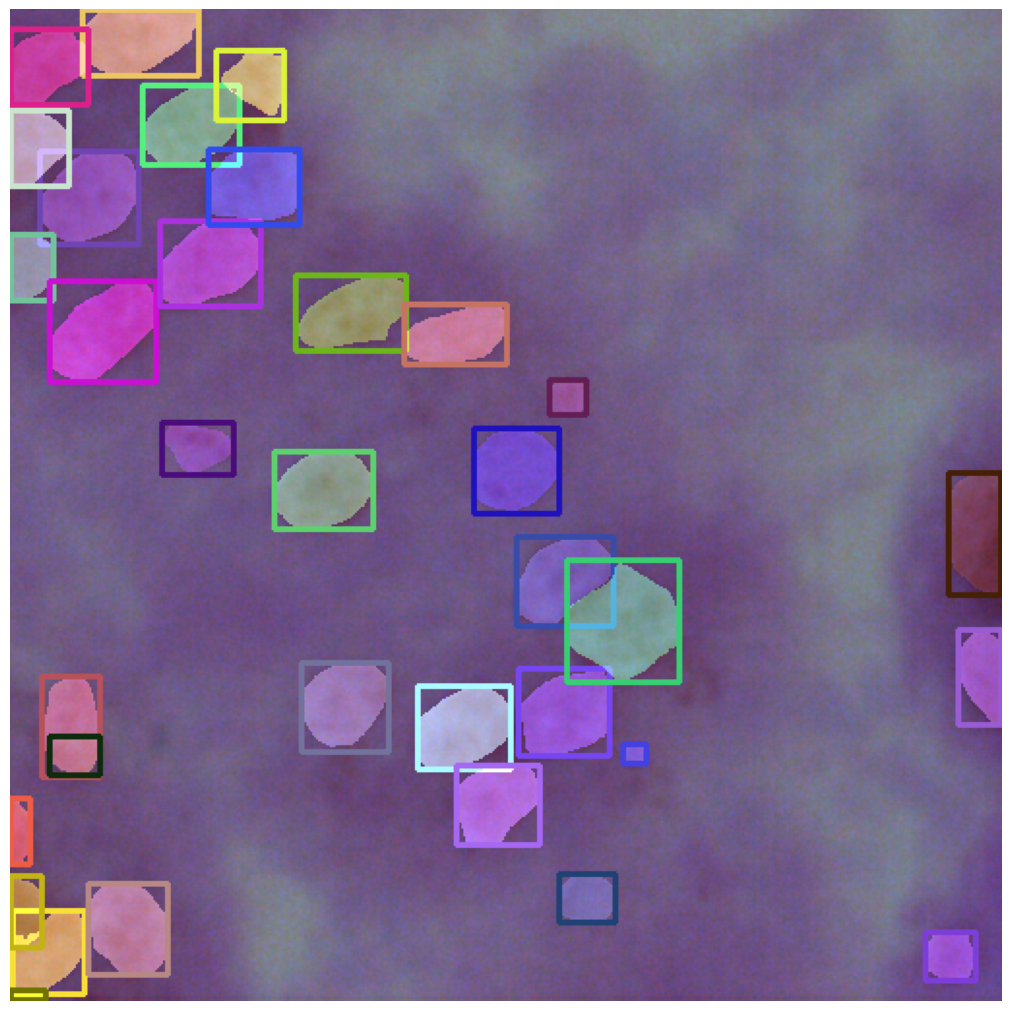